In [1]:
import os

import torch
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import Othello

from tqdm.auto import trange

from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

from collections import deque

# GAE General Advantage Estimation

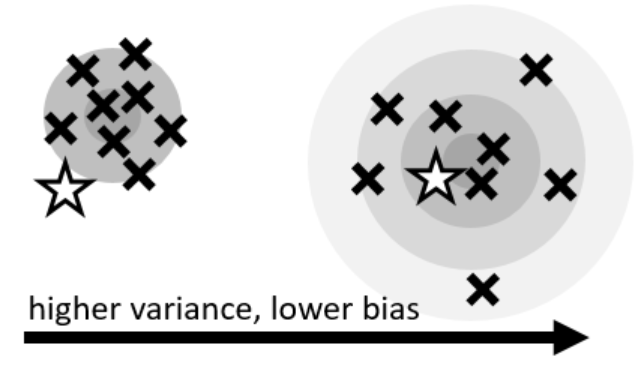

Increasing bias reduces variance and improves overall accuracy. 

$$
V^{\pi_\theta}(S_t) = E_{\tau_{A_t:A_T}\sim\pi_\theta}[R(\tau )\mid S_t]
$$

Since $ V^{\pi_\theta}(S_t) $ cannot be directly calculated, a neural network is typically used to predict $ V_\phi(S_t) $ to estimate it.

$$
\begin{align}
\phi^* 
&= \arg \min_\phi \mathbb E_{S_t \sim\pi_\theta} \left[ (V_\phi(S_t)-V^{\pi_\theta}(S_t))^2 \right] \\
%
&= \arg \min_\phi \mathbb E_{S_t \sim\pi_\theta} \left[ (V_\phi(S_t) - \mathbb E_{\tau_{A_t:A_T}\sim\pi_\theta}[R(\tau )\mid S_t])^2 \right] \\
%
&= \arg \min_\phi \mathbb E_{S_t \sim\pi_\theta} \left[ V_\phi^2(S_t) - 2V_\phi(S_t)\mathbb E_{\tau_{A_t:A_T}\sim\pi_\theta}[R(\tau )\mid S_t]+ (E_{\tau_{A_t:A_T}\sim\pi_\theta}[R(\tau )\mid S_t])^2 \right] \\
%
&= \arg \min_\phi \mathbb E_{S_t \sim\pi_\theta} \left[ V_\phi^2(S_t) - 2V_\phi(S_t)\mathbb E_{\tau_{A_t:A_T}\sim\pi_\theta}[R(\tau )\mid S_t]+ E_{\tau_{A_t:A_T}\sim\pi_\theta}[R(\tau )\mid S_t]^2 \right] \\
%
&= \arg \min_\phi \mathbb E_{\tau_{S_t:} \sim\pi_\theta} \left[ (V_\phi(S_t)-R(\tau ))^2 \right] \\
\end{align}
$$

$$
Advantage(S_t, A_t) = R_t + V_\phi(S_t) - V_\phi(S_{t+1})
$$


In [2]:
if torch.cuda.is_available():
    device = 'cuda'
else: device = 'cpu'

# the setting of game
n = 8
aim = "win" # "loss"

# model setting 
bone = "ResNet" # ResNet for lightweight model, ViT for large model
config = {"dims": [1, 64, 128, 256, 128, 64, 1], "kernel_size": 5}

# train parameters
n_epoch = 20000
batch_size_envs = 128
batch_size_ppo = 2048
lr_actor = 1e-4
lr_critic = 1e-4

# PPO parameters
reuse_time = 2
epsilon = 0.1 # the thresholds of clip
beta = 0.5 # the weight of KL

path = f"PPOcritic_n={n}_epsilon={epsilon}_beta={beta}_bone={bone}_{aim}"

In [3]:
envs = Othello.Envs(n, batch_size_envs, device)

actor = Othello.Actor(n, bone, **config).to(device)
critic = Othello.Critic(n, bone, **config).to(device)

opt = optim.Adam(actor.parameters(), lr=lr_actor) 
opt_critic = optim.Adam(critic.parameters(), lr=lr_critic)

In [4]:
baseline = Othello.Actor(n, 'ResNet').to(device)
baseline.load_state_dict(
        torch.load(f"model/n={n}_beta=0.5_bone=ResNet_{aim}/epoch_bestVsRandom.pth")
    )

<All keys matched successfully>

In [5]:
TIMESTAMP = f"{datetime.now():%Y-%m-%dT%H-%M-%S}"

writer = SummaryWriter(log_dir=f"tf_dir/{path}/{TIMESTAMP}/")

In [6]:
class ReplayBuffer:
    def __init__(self, envs, agents, batch_num):
        self.envs = envs
        self.n = envs.n
        self.batch_size = envs.batch_size

        self.agents = agents
        if isinstance(agents, list):
            assert len(agents) == 2, "Othello requires two players"
        else:
            self.agents = [agents, agents]  # self-playing game

        for agent in self.agents:
            if isinstance(agent, torch.nn.Module):
                self.device = next(agent.parameters()).device

        self.rounds = self.n * (self.n + 1)
        self.batch_num = batch_num

        self.data = deque(maxlen=batch_num * self.batch_size * self.rounds)  # S A P R

        for _ in range(batch_num):
            self.__update()
            
    @torch.no_grad()
    def __update(self):
        
        for agent in self.agents:
            agent = agent.eval()

        batch_size = self.batch_size

        rounds = self.rounds

        obs, reward, terminated, _, _ = self.envs.reset()

        boards = torch.zeros(
            (batch_size, 2, rounds // 2, self.n, self.n), device=self.device
        )
        valids = torch.zeros(
            (batch_size, 2, rounds // 2, self.n * self.n + 1), device=self.device
        )  # boards + valids == S
        actions = torch.zeros(batch_size, 2, rounds // 2, device=self.device).type(
            torch.int64 
        )  # the chosen actions
        rewards = torch.zeros(batch_size, 2, rounds // 2, device=self.device)  # rewards
        terminateds = torch.zeros(
            batch_size, 2, rounds // 2, device=self.device
        )  # whether the game is terminated
        probs = torch.zeros(
            batch_size, 2, rounds // 2, device=self.device
        )  # the probs of the chosen actions
        boards_next = torch.zeros((batch_size, 2, rounds // 2, self.n, self.n), device=self.device)
        valids_next = torch.zeros((batch_size, 2, rounds // 2, self.n * self.n + 1), device=self.device)

        for i in range(rounds // 2):
            for p in range(2):

                boards[:, p, i] = obs[0]
                valids[:, p, i] = obs[1]

                valid = obs[1]

                agent = self.agents[p]

                prob = agent(obs).float() * valid 
                # change the prob of invalid moves to 0

                # randomly choose the next move on the prob distributation
                actions[:, p, i] = torch.multinomial(prob, num_samples=1).view(-1)
                probs[:, p, i] = (
                    F.one_hot(actions[:, p, i], num_classes=n * n + 1) * prob
                ).sum(-1)

                # save reward & terminated
                rewards[:, p, i] = reward
                terminateds[:, p, i] = terminated

                # next step
                act = F.one_hot(actions[:, p, i], num_classes=n * n + 1)
                obs, reward, terminated, _, _ = envs.step(act, restart=False)
                
                boards_next[:, p, i] = obs[0]
                valids_next[:, p, i] = obs[1]

        # caculate hat_R
        Reward = torch.zeros(batch_size, 2, rounds // 2, device=self.device)
        tmp = torch.zeros(batch_size, 2, device=self.device)

        for i in range(rounds // 2 - 1, -1, -1):
            for p in range(2):

                Reward[:, p, i] = (
                    rewards[:, p, i] + (1 - terminateds[:, p, i]) * tmp[:, p]
                )  # Truncate the reward when the game is terminated

            tmp = Reward[:, :, i]

        boards = boards.flatten(0, 2).detach().cpu()
        valids = valids.flatten(0, 2).detach().cpu()
        actions = actions.flatten(0, 2).detach().cpu()
        probs = probs.flatten(0, 2).detach().cpu()
        Reward = Reward.flatten(0, 2).detach().cpu()
        boards_next = boards_next.flatten(0, 2).detach().cpu()
        valids_next = valids_next.flatten(0, 2).detach().cpu()
        
        for i in range(len(boards)):
            self.data.append((boards[i], valids[i], actions[i], probs[i], Reward[i], boards_next[i], valids_next[i]))
                    
    def update(self, n=1):

        for _ in range(n):
            self.__update()

    def getDataset(self):

        class ArchiveDataset(Dataset):
            def __init__(self, data):
                self.data = data

            def __len__(self):
                return len(self.data)

            def __getitem__(self, idx):
                
                b, v, A, P, R, bn, vn = self.data[idx]
                
                return ((b, v), A, P, R, (bn, vn))

        return ArchiveDataset(self.data)

In [7]:
def recursTo(data, device):
    if isinstance(data, tuple):
        return tuple(recursTo(item, device) for item in data)
    elif isinstance(data, list):
        return [recursTo(item, device) for item in data]
    elif isinstance(data, dict):
        return {key: recursTo(value, device) for key, value in data.items()}
    elif isinstance(data, torch.Tensor):
        return data.to(device)
    else:
        return data

In [8]:
def Vloss(critic, data):
    
    device = next(critic.parameters()).device
    
    S, A, P, R, S_next = recursTo(data, device)
    
    V = critic(S_next)
    
    return ((V - R)**2).mean()

In [9]:
def PPOloss(agent, critic, data, epsilon, beta):
    
    device = next(agent.parameters()).device
    
    S, A, P, R, S_next = recursTo(data, device)
    
    probs = agent(S)
    prob = torch.gather(probs, dim=1, index=A.reshape(-1, 1)).reshape(-1)
    
    with torch.no_grad():
        R = (critic(S_next) - critic(S)).detach()
    
    ratio = prob / P
    
    L = torch.min(ratio * R, torch.clip(ratio, 1-epsilon, 1+epsilon) * R)
    
    # cross entropy
    valid = S[-1]
    PriDis = ((1 - (valid == 0).sum(1) * 1e-6) / valid.sum(1))[:,None] * valid + 1e-6 * (valid == 0) # invalid move for 1e-6
    KLs = (probs * (torch.log(probs + 1e-6) - torch.log(PriDis))).sum(1) # add 1e-6 to prevent -inf
    
    # Add negative sign due to gradient descent 
    if aim == "win":
        L = -L
    elif aim == "loss":
        L = L
        
    return L.mean() + beta * KLs.mean(), {"KLloss": KLs.mean().item()}

In [10]:
@torch.no_grad()
def Test(agents, envs, n, times=10, strategy='biggest'):
    
    if isinstance(agents, list):
        assert len(agents) == 2, "Othello requires two players" 
    else:
        agents = [agents, agents] # self-playing game
    
    for agent in agents:
        if isinstance(agent, torch.nn.Module):
            device = next(agent.parameters()).device
    
    batch_size = envs.batch_size
    rounds = n * (n + 1) 
    
    blackWin = 0
    whiteWin = 0
    
    for k in range(times):
    
        obs, reward, _, _, _ = envs.reset()

        actions = torch.zeros(batch_size, 2, rounds//2, device=device).type(torch.int64) # the chosen actions
        rewards = torch.zeros(batch_size, 2, rounds//2, device=device)

        for i in range(rounds//2): 
            for p in range(2): 

                valid = obs[-1]

                agent = agents[p]

                prob = agent(obs).float() * valid # change the prob of invalid moves to 0

                if strategy == "biggest":
                    # choose the next move with the biggest prob
                    actions[:, p, i] = prob.max(-1)[1].view(-1)
                elif strategy == "random":
                    # randomly choose the next move on the prob distributation
                    actions[:, p, i] = torch.multinomial(prob, num_samples=1).view(-1)

                # save reward
                rewards[:, p, i] = reward

                # next step
                act = F.one_hot(actions[:, p, i], num_classes=n*n+1)
                obs, reward, terminated, _, _ = envs.step(act, restart=False)

        black_win = (rewards[:, 0].sum(-1) > 0).sum() / batch_size
        white_win = (rewards[:, 1].sum(-1) > 0).sum() / batch_size
        
        blackWin += black_win / times
        whiteWin += white_win / times
    
    tie = 1 - blackWin - whiteWin

    return {"Prob of black win": blackWin.item(), "Prob of white win": whiteWin.item(), "Prob of tie": tie.item()}

In [11]:
cnt = 0
res_train = {'KLloss': 0, 'Vloss': 0}

archiver = ReplayBuffer(envs, actor, batch_num=1)

for i in trange(n_epoch):
    
    archiver.update()
    
    dataset = archiver.getDataset()
    dataloader = DataLoader(dataset, batch_size=batch_size_ppo, shuffle=True)
    
    # Trainning Critic
    for j in range(reuse_time):
        
        for data in dataloader:
            
            critic = critic.train()
            
            loss = Vloss(critic, data)
            
            opt_critic.zero_grad()
            loss.backward()
            opt_critic.step()
            
            res_train['Vloss'] += loss.item()
            
    # Trainning Actor
    for j in range(reuse_time):
        
        for data in dataloader:
            
            actor = actor.train()
            
            loss, detail = PPOloss(actor, critic, data, epsilon=epsilon, beta=beta)
            
            opt.zero_grad()
            loss.backward()
            opt.step()
            
            cnt += 1
            res_train['KLloss'] += detail['KLloss']
            
    if i % (n_epoch // 1000) == (n_epoch // 1000) - 1 or i == 0:
        
        actor = actor.eval()
        
        res = Test([actor, envs.randomAction], envs, n, times=10)
        print('Black Agent, White Random:') 
        for key, value in res.items():
            print(f"{key}: {value:7.2%}", end='; ')
        print('\n')
        
        writer.add_scalar("Agent Black Win", res["Prob of black win"], i)
        
        res = Test([envs.randomAction, actor], envs, n, times=10)
        print('Black Random, White Agent:') 
        for key, value in res.items():
            print(f"{key}: {value:7.2%}", end='; ')
        print('\n')
        
        writer.add_scalar("Agent White Win", res["Prob of white win"], i)
        
        res = Test([actor, baseline], envs, n, times=10, strategy='random')
        print('Black Agent, White Baseline:') 
        for key, value in res.items():
            print(f"{key}: {value:7.2%}", end='; ')
        print('\n')
        
        writer.add_scalar("Agent Black Win (Baseline)", res["Prob of black win"], i)
        
        res = Test([baseline, actor], envs, n, times=10, strategy='random')
        print('Black Baseline, White Agent:') 
        for key, value in res.items():
            print(f"{key}: {value:7.2%}", end='; ')
        print('\n')
        
        writer.add_scalar("Agent White Win (Baseline)", res["Prob of white win"], i)
        
        for key, value in res_train.items():
            writer.add_scalar(key, value / cnt, i)
            res_train[key] = 0
        cnt = 0
        
    
    if i % (n_epoch // 40) == (n_epoch // 40) - 1:
            
        if not os.path.exists(f"model/{path}/{TIMESTAMP}/actor"):
            os.makedirs(f"model/{path}/{TIMESTAMP}/actor")
        if not os.path.exists(f"model/{path}/{TIMESTAMP}/critic"):
            os.makedirs(f"model/{path}/{TIMESTAMP}/critic")
        
        torch.save(actor.state_dict(), f"model/{path}/{TIMESTAMP}/actor/epoch{i}.pth")
        torch.save(critic.state_dict(), f"model/{path}/{TIMESTAMP}/critic/epoch{i}.pth")

  0%|          | 0/20000 [00:00<?, ?it/s]

Black Agent, White Random:
Prob of black win:  47.50%; Prob of white win:  48.83%; Prob of tie:   3.67%; 

Black Random, White Agent:
Prob of black win:  38.28%; Prob of white win:  58.36%; Prob of tie:   3.36%; 

Black Agent, White Baseline:
Prob of black win:  26.09%; Prob of white win:  70.78%; Prob of tie:   3.12%; 

Black Baseline, White Agent:
Prob of black win:  67.81%; Prob of white win:  28.83%; Prob of tie:   3.36%; 

Black Agent, White Random:
Prob of black win:  80.63%; Prob of white win:  16.72%; Prob of tie:   2.66%; 

Black Random, White Agent:
Prob of black win:  15.23%; Prob of white win:  82.42%; Prob of tie:   2.34%; 

Black Agent, White Baseline:
Prob of black win:  27.34%; Prob of white win:  69.45%; Prob of tie:   3.20%; 

Black Baseline, White Agent:
Prob of black win:  63.05%; Prob of white win:  33.28%; Prob of tie:   3.67%; 

Black Agent, White Random:
Prob of black win:  78.28%; Prob of white win:  19.22%; Prob of tie:   2.50%; 

Black Random, White Agent:
Pr